# Cal-CRAI Index: Governance Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [ ]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.cal_crai_plotting import plot_domain_score, plot_region_domain
from scripts.utils.cal_crai_calculations import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# domain-specific
domain_prefix = 'governance_'

input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'
merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 15 CSV files within governance_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_governance_metrics.csv


### Take a look at the resulting dictionary
We will use this later to refactor 'resilient' metrics

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_sampled_wells_contaminated'],
 'resilient': ['nfip_participation',
  'total_emergency_management_funding',
  'num_emergency_medical_technicians_and_paramedics_employed_per_10000',
  'num_firefighting_and_prevention_workers_employed_per_10000',
  'num_fire_stations_per_10000_people',
  'num_flood_policies',
  'total_hazard_mitigation_funding',
  'housing_units_with_mortgage',
  'percent_prepared_for_general_disaster',
  'percent_prepared_without_power',
  'percent_prepared_without_water',
  'num_police_officers_employed_per_10000',
  'num_registered_nurses_employed_per_10000',
  'percent_under_timber_management']}

### Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_governance_df = pd.read_csv(merged_output_file)
processed_governance_df

,GEOID,nfip_participation,total_emergency_management_funding,num_emergency_medical_technicians_and_paramedics_employed_per_10000,num_firefighting_and_prevention_workers_employed_per_10000,num_fire_stations_per_10000_people,num_flood_policies,total_hazard_mitigation_funding,housing_units_with_mortgage,percent_prepared_for_general_disaster,percent_prepared_without_power,percent_prepared_without_water,num_police_officers_employed_per_10000,num_registered_nurses_employed_per_10000,percent_under_timber_management,percent_sampled_wells_contaminated
0,6001400100,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
1,6001400200,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
2,6001400300,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
3,6001400400,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
4,6001400500,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,1188864.0,3.671746,6.119577,1.468698,586.0,1.129758e+07,67.5,50.000000,100.000000,100.000000,31.209840,70.987088,0.573947,57.142857
9125,6115041001,1.0,1188864.0,3.671746,6.119577,1.468698,586.0,1.129758e+07,67.5,50.000000,100.000000,100.000000,31.209840,70.987088,0.573947,83.333333
9126,6115041002,1.0,1188864.0,3.671746,6.119577,1.468698,586.0,1.129758e+07,67.5,50.000000,100.000000,100.000000,31.209840,70.987088,0.573947,38.888889
9127,6115041101,1.0,1188864.0,3.671746,6.119577,1.468698,586.0,1.129758e+07,67.5,50.000000,100.000000,100.000000,31.209840,70.987088,0.573947,58.823529


### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [6]:
# standardizing our df
columns_to_process = [col for col in processed_governance_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_governance_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate for GEOID and standardized columns exclusively

In [7]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_governance_metrics_df = min_max_metrics[selected_columns]

In [8]:
min_max_standardized_governance_metrics_df

,GEOID,nfip_participation_min_max_standardized,total_emergency_management_funding_min_max_standardized,num_emergency_medical_technicians_and_paramedics_employed_per_10000_min_max_standardized,num_firefighting_and_prevention_workers_employed_per_10000_min_max_standardized,num_fire_stations_per_10000_people_min_max_standardized,num_flood_policies_min_max_standardized,total_hazard_mitigation_funding_min_max_standardized,housing_units_with_mortgage_min_max_standardized,percent_prepared_for_general_disaster_min_max_standardized,percent_prepared_without_power_min_max_standardized,percent_prepared_without_water_min_max_standardized,num_police_officers_employed_per_10000_min_max_standardized,num_registered_nurses_employed_per_10000_min_max_standardized,percent_under_timber_management_min_max_standardized,percent_sampled_wells_contaminated_min_max_standardized
0,6001400100,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
1,6001400200,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
2,6001400300,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
3,6001400400,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
4,6001400500,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,0.037176,0.000885,0.001775,0.175226,0.029114,0.013629,0.716346,0.50000,1.000000,1.000000,0.008061,0.003854,0.117971,0.571429
9125,6115041001,1.0,0.037176,0.000885,0.001775,0.175226,0.029114,0.013629,0.716346,0.50000,1.000000,1.000000,0.008061,0.003854,0.117971,0.833333
9126,6115041002,1.0,0.037176,0.000885,0.001775,0.175226,0.029114,0.013629,0.716346,0.50000,1.000000,1.000000,0.008061,0.003854,0.117971,0.388889
9127,6115041101,1.0,0.037176,0.000885,0.001775,0.175226,0.029114,0.013629,0.716346,0.50000,1.000000,1.000000,0.008061,0.003854,0.117971,0.588235


### 1d) Set resilience orientation
* High values indicate resiliency
* Low values indicate vulnerablility

Some metrics indicate a communities vulnerablity rather than resilience. For example, 'Number of Violent Crimes per 10,000 Population' represents a communities vulnerability to violent crime. For this metric, the higher the number, the more vulnerable. So we identify these 'vulnerable' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate resiliency

In [9]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_sampled_wells_contaminated'],
 'resilient': ['nfip_participation',
  'total_emergency_management_funding',
  'num_emergency_medical_technicians_and_paramedics_employed_per_10000',
  'num_firefighting_and_prevention_workers_employed_per_10000',
  'num_fire_stations_per_10000_people',
  'num_flood_policies',
  'total_hazard_mitigation_funding',
  'housing_units_with_mortgage',
  'percent_prepared_for_general_disaster',
  'percent_prepared_without_power',
  'percent_prepared_without_water',
  'num_police_officers_employed_per_10000',
  'num_registered_nurses_employed_per_10000',
  'percent_under_timber_management']}

In [10]:
# Access the vulnerable column names from the dictionary
vulnerable_columns = metric_vulnerable_resilient_dict['vulnerable']

# Identify columns in the DataFrame that contain any of the vulnerable column names as substrings
vulnerable_columns_in_df = [col for col in min_max_standardized_governance_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in vulnerable_columns)]

# Create a new DataFrame with the adjusted vulnerable columns
adjusted_vulnerable_df = min_max_standardized_governance_metrics_df.copy()

# Subtract the standardized vulnerable columns from one and store the result in the new DataFrame
adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df] = (
    1 - adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df]
)

In [11]:
adjusted_vulnerable_df

,GEOID,nfip_participation_min_max_standardized,total_emergency_management_funding_min_max_standardized,num_emergency_medical_technicians_and_paramedics_employed_per_10000_min_max_standardized,num_firefighting_and_prevention_workers_employed_per_10000_min_max_standardized,num_fire_stations_per_10000_people_min_max_standardized,num_flood_policies_min_max_standardized,total_hazard_mitigation_funding_min_max_standardized,housing_units_with_mortgage_min_max_standardized,percent_prepared_for_general_disaster_min_max_standardized,percent_prepared_without_power_min_max_standardized,percent_prepared_without_water_min_max_standardized,num_police_officers_employed_per_10000_min_max_standardized,num_registered_nurses_employed_per_10000_min_max_standardized,percent_under_timber_management_min_max_standardized,percent_sampled_wells_contaminated_min_max_standardized
0,6001400100,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
1,6001400200,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
2,6001400300,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
3,6001400400,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
4,6001400500,1.0,0.186246,0.003035,0.001975,0.028052,0.131260,0.235375,0.774038,0.52381,0.571429,0.571429,0.000644,0.005391,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,0.037176,0.000885,0.001775,0.175226,0.029114,0.013629,0.716346,0.50000,1.000000,1.000000,0.008061,0.003854,0.117971,0.428571
9125,6115041001,1.0,0.037176,0.000885,0.001775,0.175226,0.029114,0.013629,0.716346,0.50000,1.000000,1.000000,0.008061,0.003854,0.117971,0.166667
9126,6115041002,1.0,0.037176,0.000885,0.001775,0.175226,0.029114,0.013629,0.716346,0.50000,1.000000,1.000000,0.008061,0.003854,0.117971,0.611111
9127,6115041101,1.0,0.037176,0.000885,0.001775,0.175226,0.029114,0.013629,0.716346,0.50000,1.000000,1.000000,0.008061,0.003854,0.117971,0.411765


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [12]:
domain_prefix[:-1]

'governance'

In [13]:
averaged_indicators_governance_systems = compute_averaged_indicators(
    adjusted_vulnerable_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_governance_systems

,GEOID,emergency_response,personal_preparedness,community_preparedness,natural_resource_conservation
0,6001400100,0.007819,0.514393,0.617688,NaN
1,6001400200,0.007819,0.514393,0.617688,NaN
2,6001400300,0.007819,0.514393,0.617688,NaN
3,6001400400,0.007819,0.514393,0.617688,NaN
4,6001400500,0.007819,0.514393,0.617688,NaN
...,...,...,...,...,...
9124,6115040902,0.037960,0.649092,0.506815,0.273271
9125,6115041001,0.037960,0.649092,0.506815,0.142319
9126,6115041002,0.037960,0.649092,0.506815,0.364541
9127,6115041101,0.037960,0.649092,0.506815,0.264868


Save Indicator dataframe as a csv

In [14]:
# set-up file for export
indicator_filename = '{}domain_averaged_indicators.csv'.format(domain_prefix)
averaged_indicators_governance_systems.to_csv(indicator_filename, index=False)

Sum the indicator columns together to calculate the domain score
* essentially summing all columns except for 'GEOID'

In [15]:
columns_to_sum = [col for col in averaged_indicators_governance_systems.columns if col != 'GEOID']
summed_indicators_governance_systems = compute_summed_indicators(
    df=averaged_indicators_governance_systems, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 2.587465119600051


### 2a) Min-max standardize the summed columns

In [16]:
columns_to_process = [col for col in summed_indicators_governance_systems.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_governance_systems, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [17]:
min_max_domain

,GEOID,summed_indicators_governance_domain_min,summed_indicators_governance_domain_max,summed_indicators_governance_domain_min_max_standardized
0,6001400100,0.0,2.587465,0.440547
1,6001400200,0.0,2.587465,0.440547
2,6001400300,0.0,2.587465,0.440547
3,6001400400,0.0,2.587465,0.440547
4,6001400500,0.0,2.587465,0.440547
...,...,...,...,...
9124,6115040902,0.0,2.587465,0.567018
9125,6115041001,0.0,2.587465,0.516407
9126,6115041002,0.0,2.587465,0.602291
9127,6115041101,0.0,2.587465,0.563770


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [18]:
governance_domain_score = min_max_domain[['GEOID', 'summed_indicators_governance_domain_min_max_standardized']].copy()

# GEOID handling
governance_domain_score['GEOID'] = governance_domain_score['GEOID'].apply(lambda x: '0' + str(x))
governance_domain_score['GEOID'] = governance_domain_score['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)
governance_domain_score = governance_domain_score.rename(columns={'summed_indicators_governance_domain_min_max_standardized':'governance_domain_score'})

In [19]:
governance_domain_score

,GEOID,governance_domain_score
0,06001400100,0.440547
1,06001400200,0.440547
2,06001400300,0.440547
3,06001400400,0.440547
4,06001400500,0.440547
...,...,...
9124,06115040902,0.567018
9125,06115041001,0.516407
9126,06115041002,0.602291
9127,06115041101,0.563770


## Step 3: Visualizing the domain


Let's look at some summary statistics for this domain:

In [20]:
domain_summary_stats(governance_domain_score, 'governance_domain_score')

Median governance_domain_score domain value: 0.4304422877853798
Mean governance_domain_score domain value: 0.4768533877759243


Now let's visualize the entire domain!

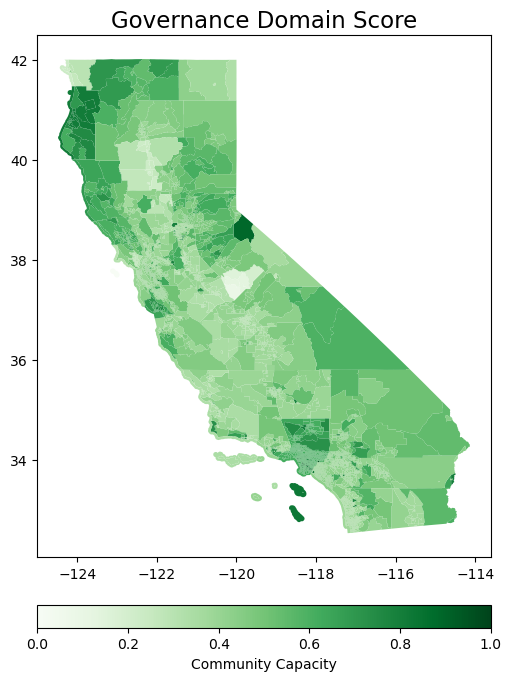

In [21]:
plot_domain_score(governance_domain_score, column_to_plot='governance_domain_score', domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


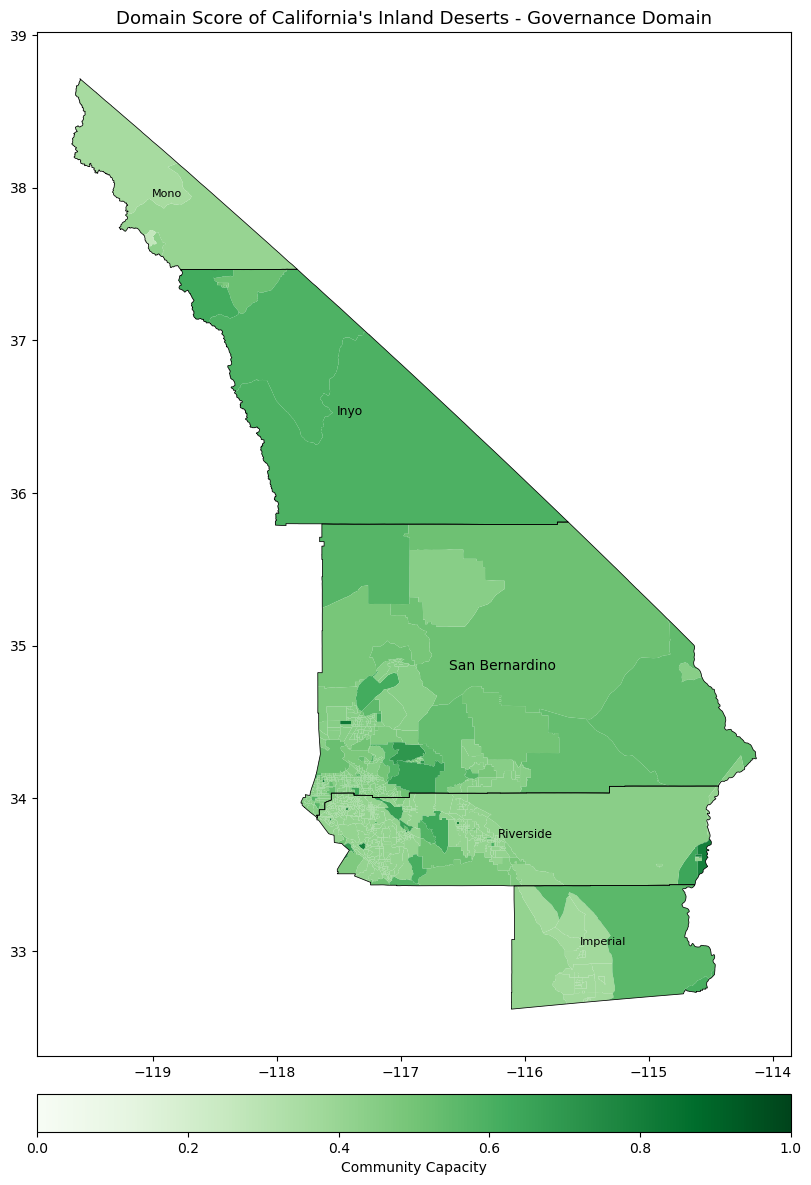

In [23]:
plot_region_domain(governance_domain_score, 
                   column_to_plot='governance_domain_score',
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Governance Domain'}, 
                   region='inland_deserts', 
                   savefig=False, 
                   font_color='black')

Number of invalid geometries: 0


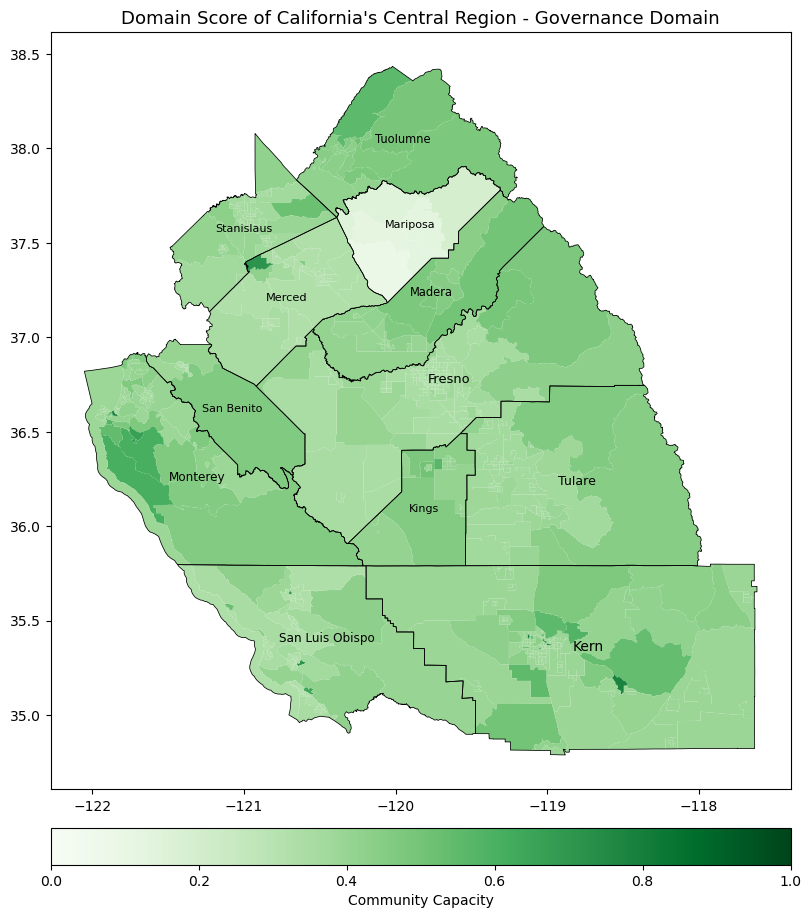

In [24]:
plot_region_domain(governance_domain_score, 
                   column_to_plot='governance_domain_score',
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Governance Domain'}, 
                   region='central_region', 
                   savefig=False, 
                   font_color='black')

Number of invalid geometries: 0


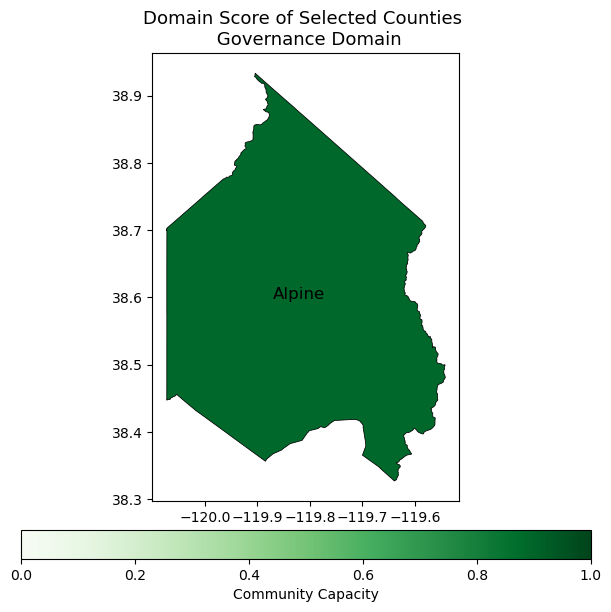

In [25]:
list_of_counties = ['003']
plot_region_domain(governance_domain_score, 
                   column_to_plot='governance_domain_score',
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Governance Domain'}, 
                   counties_to_plot=list_of_counties, 
                   savefig=False, 
                   font_color='black')

Number of invalid geometries: 0


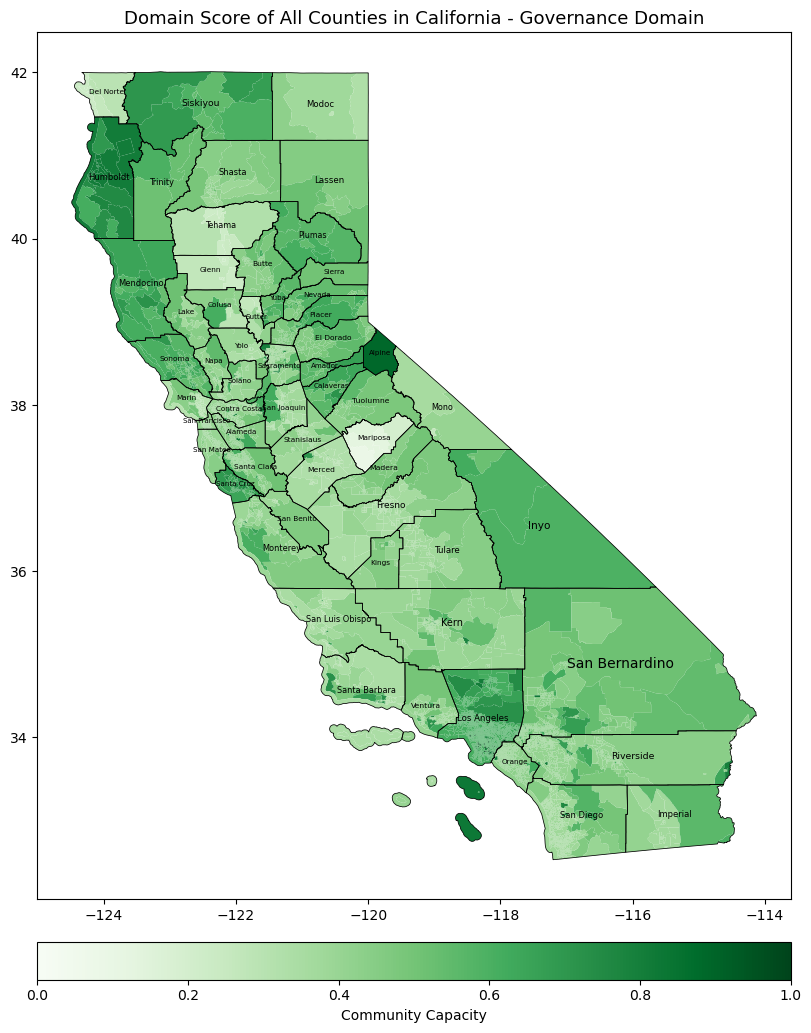

In [26]:
plot_region_domain(governance_domain_score, 
                   column_to_plot='governance_domain_score',
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Governance Domain'}, 
                   plot_all=True, 
                   savefig=False, 
                   font_color='black')

## Step 4: Export the final domain csv file

In [29]:
# set-up file for export
domain_filename = '{}domain_score.csv'.format(domain_prefix)
governance_domain_score.to_csv(domain_filename, index=False)

In [30]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

governance_domain_averaged_indicators.csv uploaded to AWS
governance_domain_score.csv uploaded to AWS
